In [2]:
#Import all the Modules Needed
%matplotlib inline

import os
import numpy as np
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import closing, opening, dilation, erosion, binary_dilation, binary_erosion, reconstruction
from skimage.filters import threshold_otsu,gaussian
from skimage.segmentation import clear_border, active_contour
from skimage.exposure import rescale_intensity
from skimage import exposure, img_as_float
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2gray, label2rgb
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2hed
from ipywidgets import interact
from skimage import color, data, filters
from scipy.spatial import ConvexHull


## Assemble File Calls

In [4]:
#This function generates an iterable list of file paths to submit later for image processing

def directory_search(directory):
    """
    This function takes the input "directory" which is a file path and returns a list containing 
    all the file paths to all folders within the directory file    
    """
    
    directory_list = [] #initialize list of lists to collect features 
    subdirectories = [f for f in os.listdir(directory) if not f.startswith('.')] #ignores hidden folders
    for i in range(len(subdirectories)):
        folder = subdirectories[i]
        subdirectory = directory+folder
        files = [f for f in os.listdir(subdirectory) if not f.startswith('.')] #ignores hidden folders
        for j in range(len(files)):
            file = files[j]
            file_name = subdirectory+'/'+file
            directory_list.append(file_name)
    return directory_list

#Assemble directory List w/above function
directory = '/Users/charlieschurman/Desktop/GitHub/schurman-python-ay250-homeworks/final-project/Silver-Nitrate/'
list_of_paths = directory_search(directory) 

In [ ]:
##Parralelize...

## Open Image

In [5]:
# Open Image 
org_image = imread(list_of_paths[2])

# Find Size
y = org_image.shape[0]
x = org_image.shape[1]

gray_image = rgb2gray(org_image)

# Normalize Image Based on Historgram of Exposure
hist_image = exposure.equalize_hist(gray_image, nbins=256, mask=None)

# Apply Otsu Binary Filter
thresh = threshold_otsu(hist_image)+.15
binary = 1*(gray_image > thresh)
binary = binary.astype('float64')
binary = ndi.median_filter(binary, size=2)

closed_image = closing(binary)
LCN_area = sum(sum(closed_image))/(x*y) # This will be in percent for now, will later change to dimension when scale is added


/Users/charlieschurman/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:3044: UserWarning: incorrect count for tag 'reference_black_white'
  warnings.warn("incorrect count for tag '%s'" % name)


## Preprocessing Image for Binary Transfrom

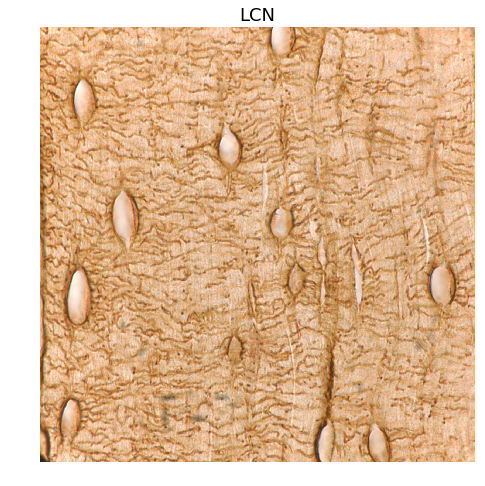

In [7]:
#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image,cmap='gray')
ax.set_axis_off()
plt.title("LCN",fontsize='18')
plt.show()

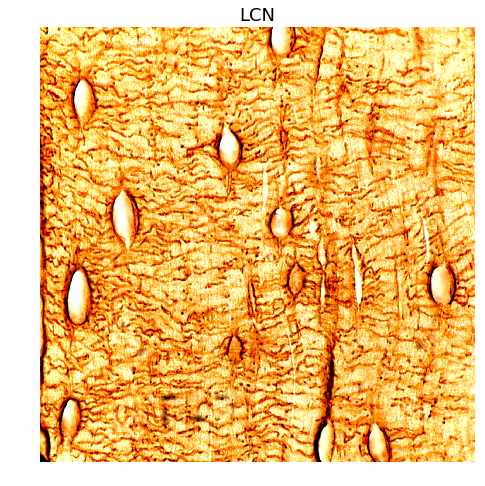

In [8]:
from skimage.exposure import rescale_intensity
image = (org_image)

# Rescale image intensity so that we can see dim features
image_rescale = rescale_intensity(image, in_range=(100, 200)) # < -- can be manually adjusted, but this range works well

#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image_rescale,cmap='gray')
ax.set_axis_off()
plt.title("LCN",fontsize='18')
plt.show()

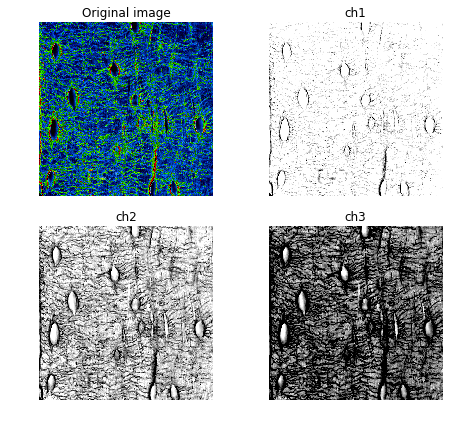

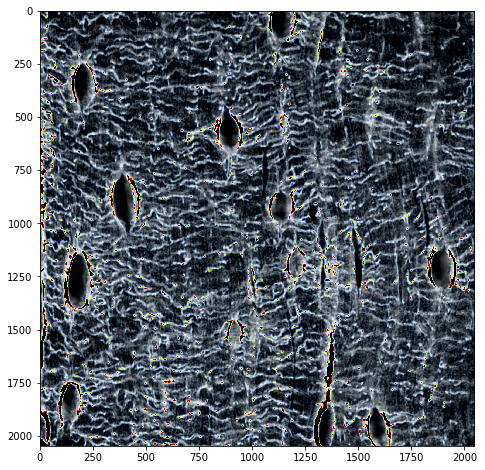

In [10]:
# Use Reconstruction/Erosion to enlarge the important features (boundaries around lacuna)
# Then use median filter to enhance contrast
# This step is computational expensive and takes a few seconds

image = image_rescale
seed = np.copy(image)
mask = image
filled = reconstruction(seed, mask, method='erosion')
img_med = ndi.median_filter(filled, size=5)



#parse filled channels
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(filled,cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(filled[:, :, 0], cmap='gray')
ax[1].set_title("ch1")

ax[2].imshow(filled[:, :, 1], cmap='gray')
ax[2].set_title("ch2")

ax[3].imshow(filled[:, :, 2], cmap='gray')
ax[3].set_title("ch3")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

fig, axes = plt.subplots(figsize=(12, 8))
plt.imshow(img_med, cmap=plt.cm.gray);

## Create Enhanced Grey Scale Image

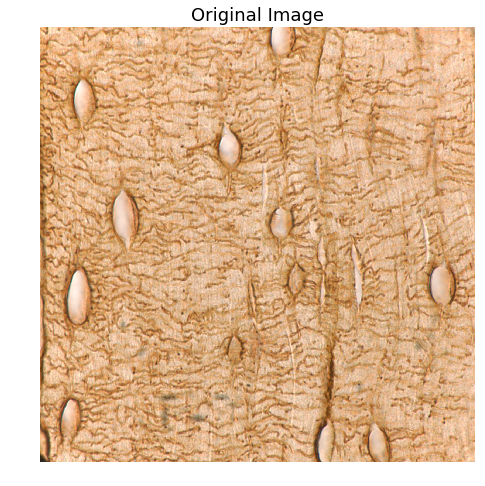

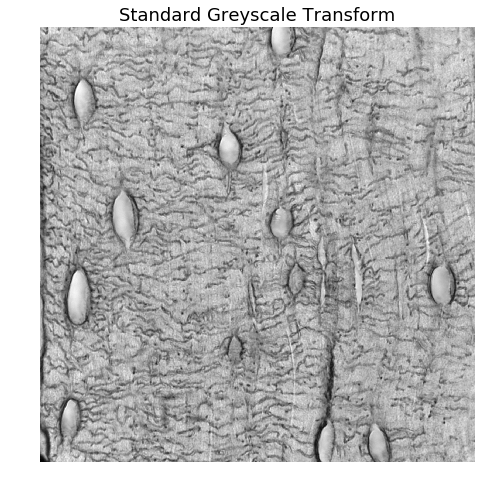

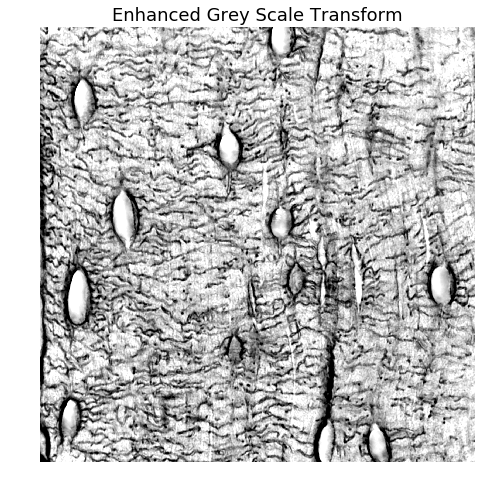

In [12]:
filt_gray_image = color.rgb2gray(img_med)
#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image,cmap='gray')
ax.set_axis_off()
plt.title("Original Image",fontsize='18')
plt.show()

#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(gray_image,cmap='gray')
ax.set_axis_off()
plt.title("Standard Greyscale Transform",fontsize='18')
plt.show()


#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(filt_gray_image,cmap='gray')
ax.set_axis_off()
plt.title("Enhanced Grey Scale Transform",fontsize='18')
plt.show()

## Isolate Lacuna (Cell Bodies) For Measurements 

A Jupyter Widget

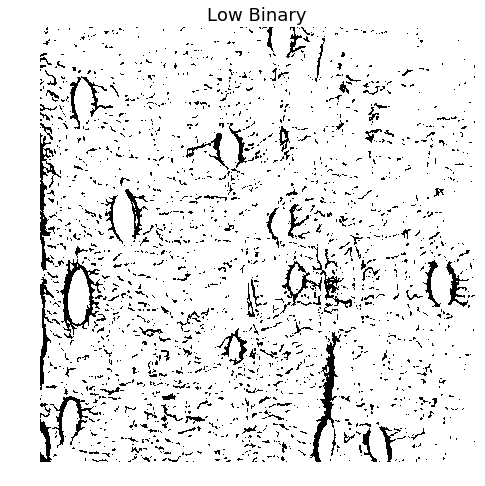

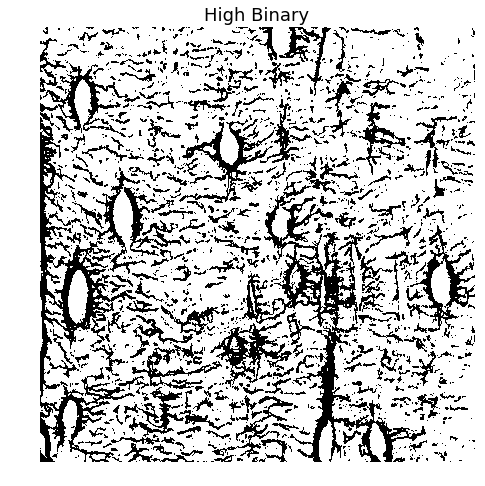

In [17]:
# Use slider to find appropriate threshold for isolating Lacuna (low binary)
# and then threshold for total LCN (high binary)
image = filt_gray_image

@interact(thresh=(10, 250, 10), )
def filter_image(thresh=150):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(
       1*(image > thresh),
        cmap='gray'
    )
    plt.show()

# Apply Binary Filter
low_binary = 1*(image > 80) # <--- Change Value Here after testing with slider bar!
high_binary = 1*(image > 140) # for total LCN calculating
empty = 1*(image > 0) #need this for mask generation later



#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(low_binary,cmap='gray')
ax.set_axis_off()
plt.title("Low Binary",fontsize='18')
plt.show()

#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(high_binary,cmap='gray')
ax.set_axis_off()
plt.title("High Binary",fontsize='18')
plt.show()


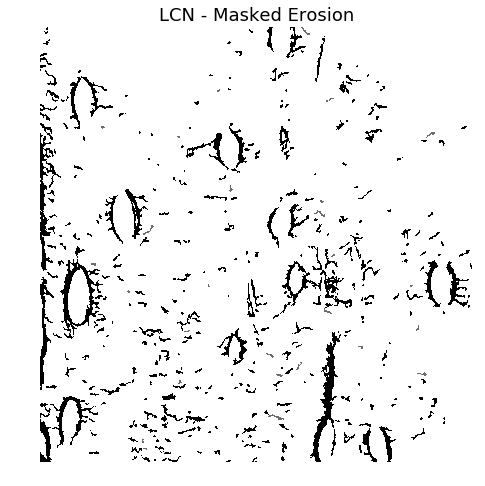

In [18]:
# Use the Binary a Mask for Erosion to remove small canaliculi not removed by filter up to now
mask = low_binary
seed = image
recon = reconstruction(seed, mask, method='erosion', selem=None, offset=None)

#Plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(recon,cmap='gray')
ax.set_axis_off()
plt.title("LCN - Masked Erosion",fontsize='18')
plt.show()


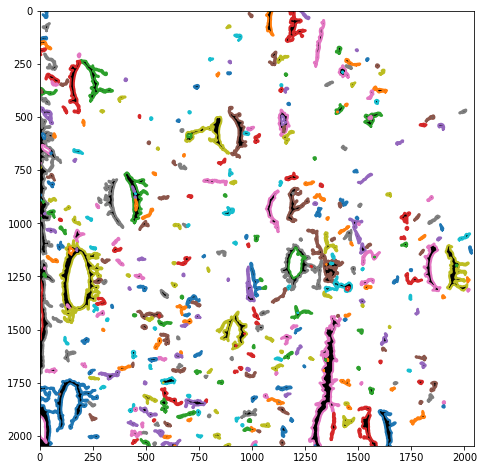

In [19]:
# Find Contours of Lacuna
contours = find_contours(recon, 0.9)
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(recon, interpolation='nearest', cmap=plt.cm.gray, )

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)  

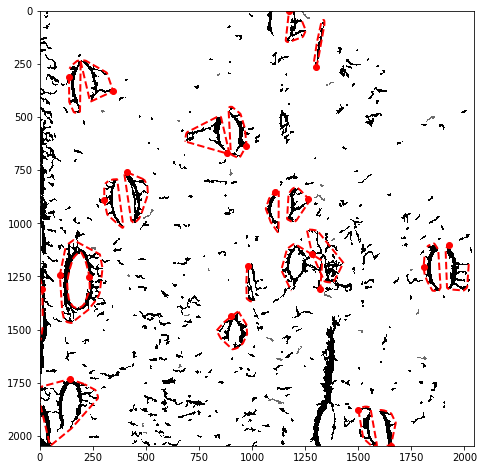

In [20]:
#Find the ConvexHull of the Points that define the Contours
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(recon, interpolation='nearest', cmap=plt.cm.gray, )

hulls=[] #Initiate collector variables
centroid=[]
comp = recon 
cont_pointsX = []
cont_pointsY = []
for n, contour in enumerate(contours):
    hull = ConvexHull(contours[n])
    if hull.area > 350 and hull.area < 1000: #this value may need manual adjusting
        hulls.append(hull) # <-- collect
        ax.plot(contours[n][hull.vertices,1], contours[n][hull.vertices,0], 'r--', lw=2)
        cont_point_x=contours[n][hull.vertices,1]
        cont_point_y=contours[n][hull.vertices,0]
        cont_pointsX.append(cont_point_x)
        cont_pointsY.append(cont_point_y)
        ax.plot(contours[n][hull.vertices[1],1], contours[n][hull.vertices[1],0], 'ro')
        x=np.mean(contours[n][hull.vertices,1])
        y=np.mean(contours[n][hull.vertices,0])
        centroid.append([x,y])

#extract the coordinates of the points for the hulls
XS=[]
YS=[]
for N in range(len(cont_pointsX)):
    for M in range(len(cont_pointsX[N])):
        XS.append(np.round(cont_pointsX[N][M]))
        YS.append(np.round(cont_pointsY[N][M]))
XS=np.asarray(XS)
YS=np.asarray(YS)

In [21]:
#Fit Ellipses to the convex hulls
# FitEllipse adapted from http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

from numpy.linalg import eig, inv

def fitEllipse(x,y):
    '''Fit ellipse to set of points X,Y'''
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(E)
    a = V[:,n]
    
    return a

def ellipse_center(a):
    '''Find the center of the ellipse based on fit parameters from fitEllipse'''
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation(a):
    '''Find the angle of rotation (in radians) of the ellipse based on fit parameters from fitEllipse'''
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))


def ellipse_axis_length(a):
    '''Find the lengths of the boundning axes of the ellipse based on fit parameters from fitEllipse'''
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])


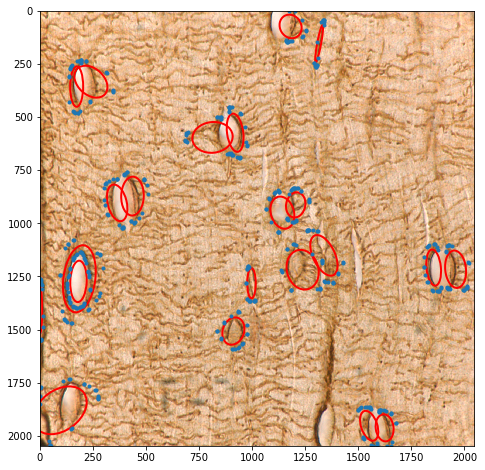

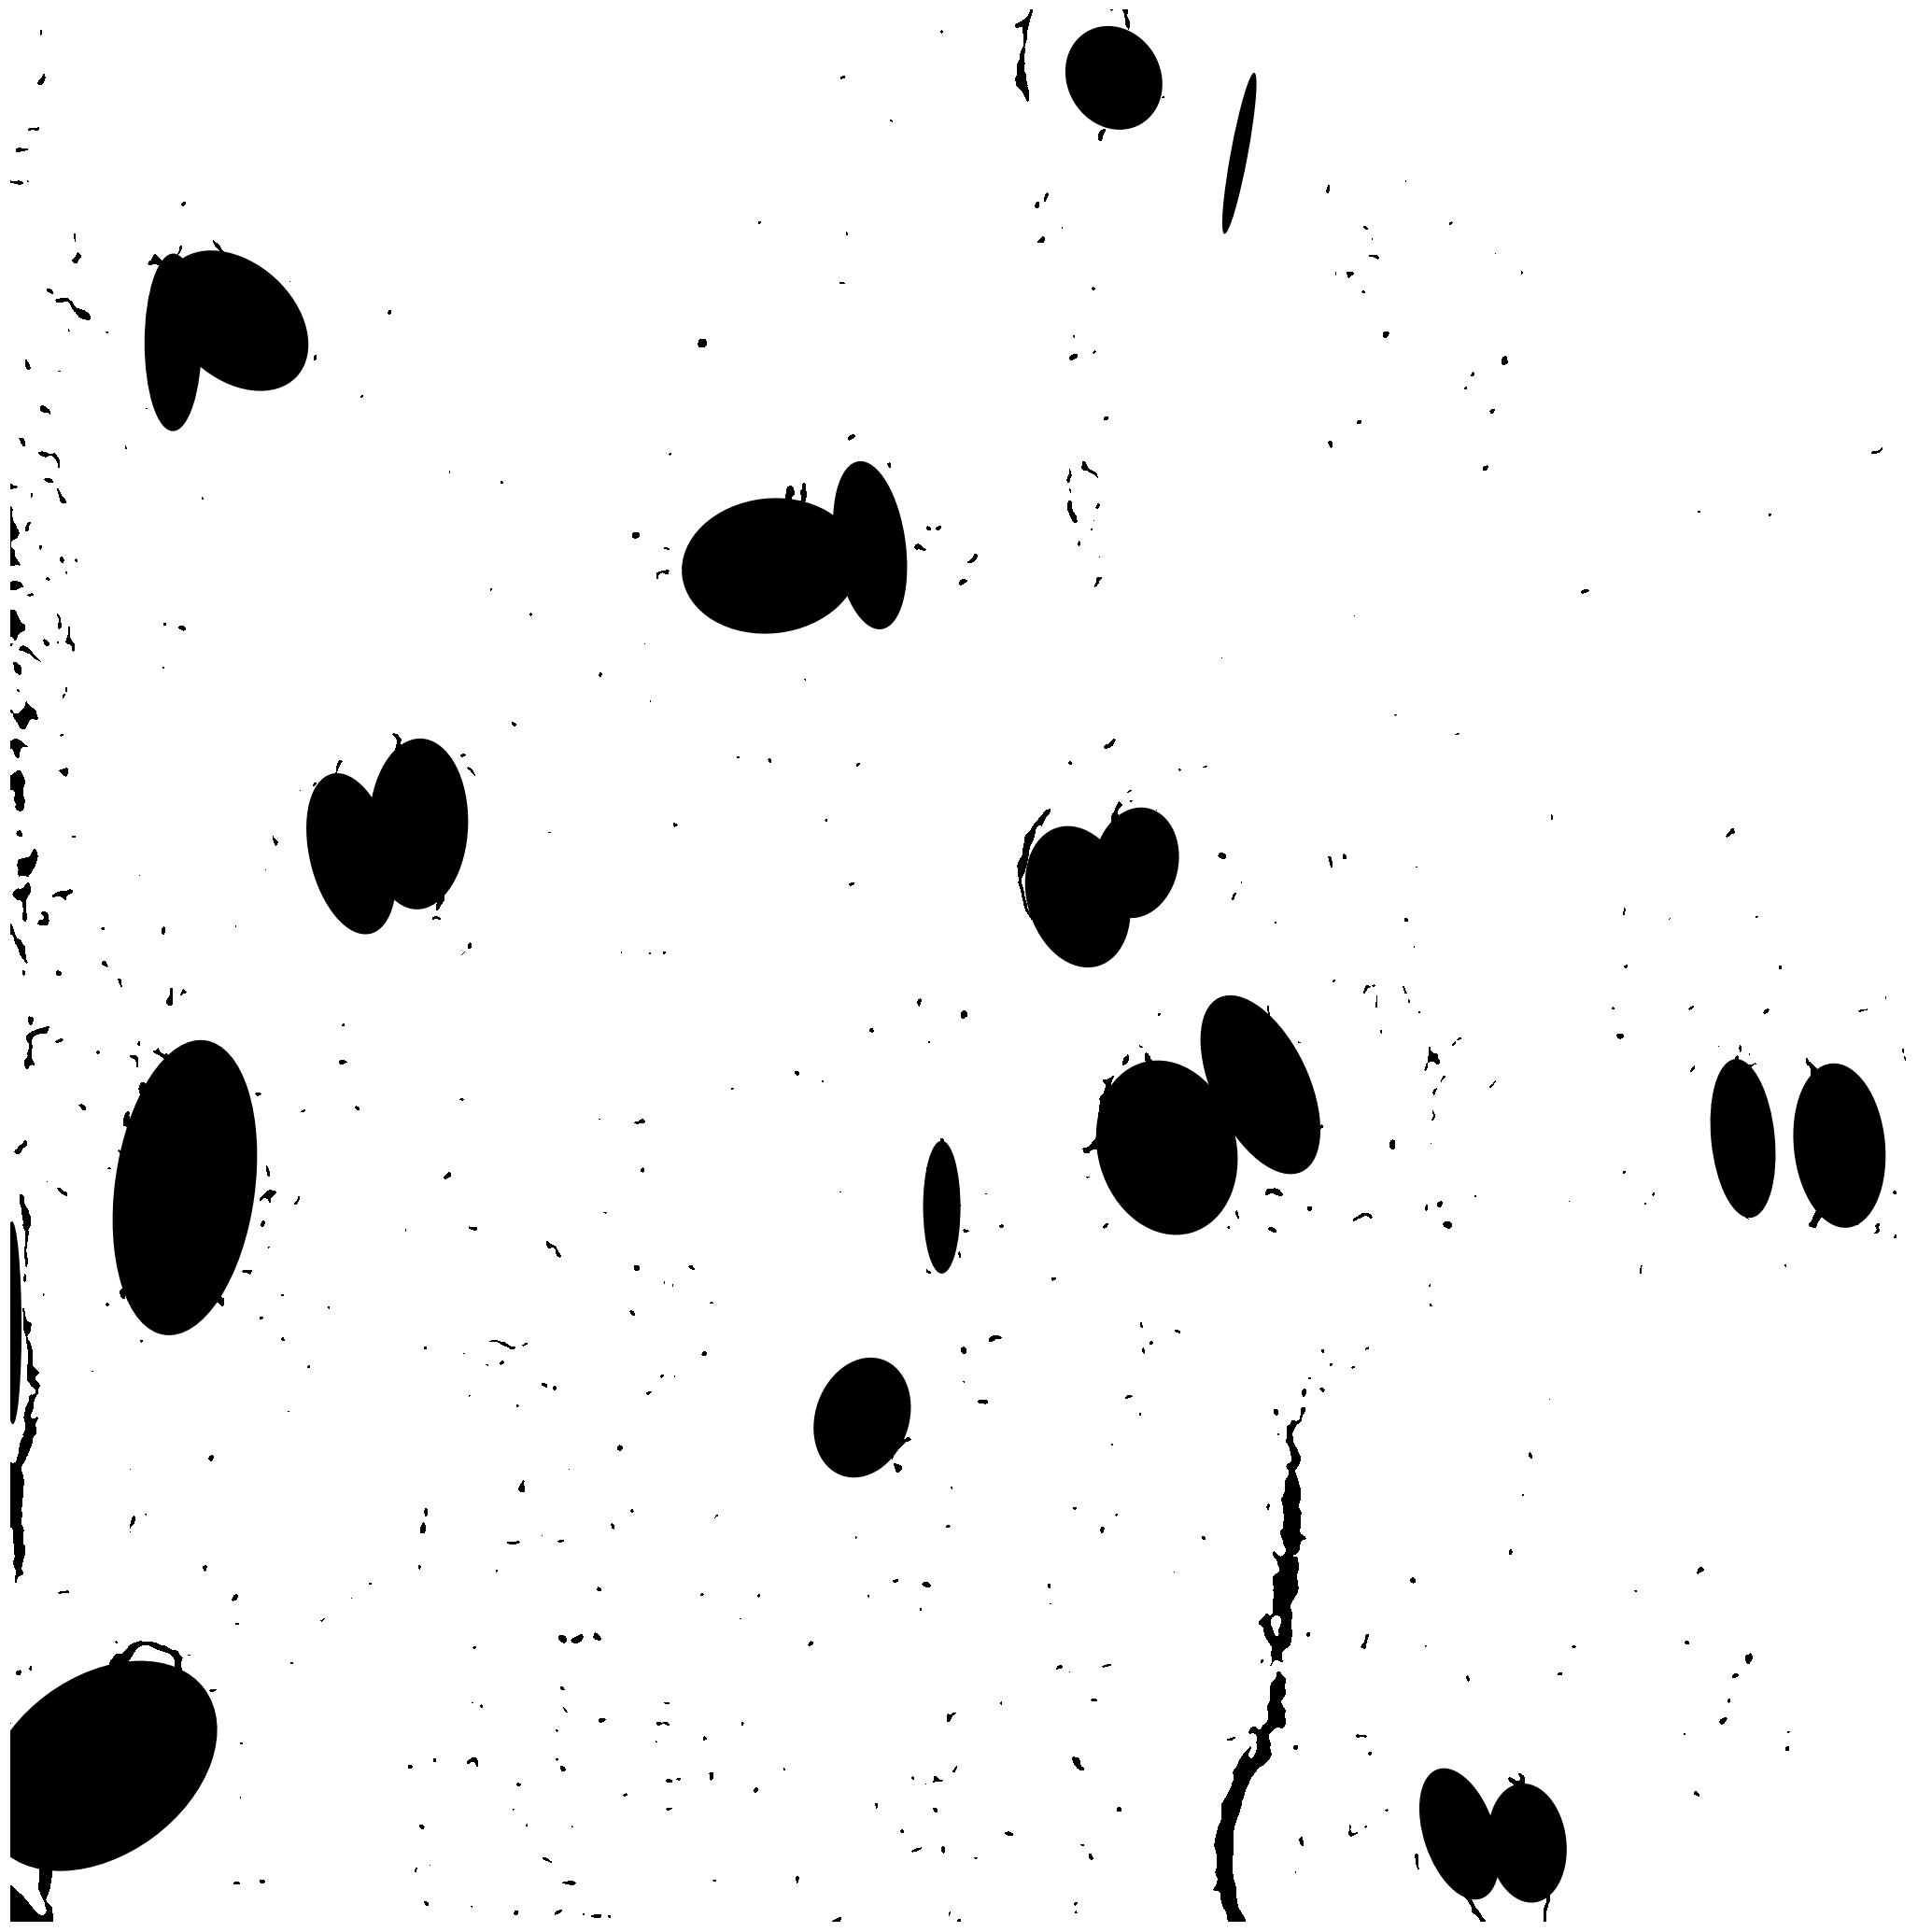

In [22]:
from matplotlib.patches import Ellipse

ellipse=[]
ellipseK=[]
#Fit Ellipses to the convex hull boundaries
for n in range(len(cont_pointsX)):
    a = fitEllipse(cont_pointsX[n],cont_pointsY[n])
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    axes = ellipse_axis_length(a)

    #Generate the Ellipse Patch object to plot fitted
    ellipse.append(Ellipse(center, width=axes[0]*1.5, height=axes[1]*1.5, angle=phi*(180/np.pi), 
                        edgecolor='r', fc='None', lw=2)) #angle for plotting is in deg, convert from radian
    ellipseK.append(Ellipse(center, width=axes[0]*1.5, height=axes[1]*1.5, angle=phi*(180/np.pi), 
                        edgecolor='None', fc='k', lw=2)) #filled Elipses, used for masking later

# Plot Points 1st
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image)
ax.plot(XS,YS,'.') #fitted points

for e in ellipse:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
plt.show()

#Make Mask from Filled Ellipses
# get the dimensions from reference
ypixels, xpixels = recon.shape
# get the size in inches
dpi = 72.
xinch = xpixels / dpi
yinch = ypixels / dpi

# plot and save in the same size as the original
fig = plt.figure(figsize=(xinch,yinch))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
ax.imshow(empty,interpolation = 'none',cmap='gray')
for e in ellipseK:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)

plt.savefig("mask.png", bbox_inches='tight')
plt.show()

mask = imread("mask.png")
mask = rgb2gray(mask)
mask = mask[:recon.shape[0],:recon.shape[1]]

## Find Canalicular Area


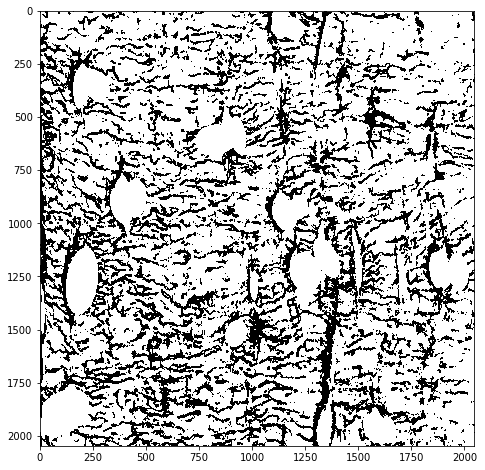

In [43]:
#Create Binary Image of Canaliculi alone (Minus the Lacunar Mask)
cans = mask-high_binary
cans = 1-(1*(cans > 0))
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cans, interpolation='nearest', cmap=plt.cm.gray)

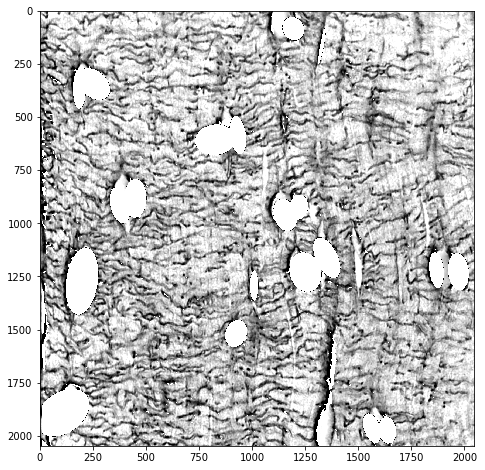

In [81]:
filt_gray = np.empty(gray_image.shape)
for i in range(len(gray_image)):
    for j in range(len(gray_image)):
        if mask[i,j] == 1:
            filt_gray[i,j] = filt_gray_image[i,j]
        elif mask[i,j] == 0:
            filt_gray[i,j] = 255

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(filt_gray, interpolation='nearest', cmap=plt.cm.gray)

In [ ]:
# Line finding using the Probabilistic Hough Transform - This computationally expensive for the computer
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from matplotlib import cm

image = filt_gray
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)


# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

# ax[2].imshow(edges * 0)
# for line in lines:
#     p0, p1 = line
#     ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
# ax[2].set_xlim((0, image.shape[1]))
# ax[2].set_ylim((image.shape[0], 0))
# ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
#Avg lacunar Size (in pixels^2)
Lacunar_Number = len(hulls)
area=0
for n, hullz in enumerate(hulls):
    hull = hulls[n]
    area+=hull.area
avg_area = area/Lacunar_Number
LCN_area = sum(sum(high_binary))/(x*y) # This will be in percent for now, will later change to dimension when scale is added